<a href="https://colab.research.google.com/github/emreavcioglu/Dog-Breed-Classifier/blob/main/Dog_Breeds_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.optimizers.schedules import CosineDecay
from collections import Counter
from PIL import Image
from tensorflow.keras import mixed_precision
from google.colab import drive

mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Wed Sep 24 17:58:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Copying dataset onto local ssd and path

In [ ]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/Dog Breeds Image Dataset" "/content/dataset"

Path

In [ ]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/Dog Breeds Image Dataset"
print("Number of classes:", len(os.listdir(dataset_path)))
print("First 5 breeds:", os.listdir(dataset_path)[:5])

Number of classes: 157
First 5 breeds: ['affenpinscher', 'afghan_hound', 'african', 'australian_terrier', 'american_terrier']


Working Directory

In [ ]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier")
!pwd

/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier


Config

In [ ]:
img_size = (224, 224)
batch_size = 32
num_classes = len(os.listdir(dataset_path))

File paths and labels


In [ ]:
all_image_paths = []
all_labels = []
class_names = sorted(os.listdir(dataset_path))

for label, class_name in enumerate(class_names):
    class_dir = os.path.join(dataset_path, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith((".jpg",".png",".jpeg",".bmp",".gif")):
            all_image_paths.append(os.path.join(class_dir,fname))
            all_labels.append(label)

all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

counts = Counter(all_labels)
rare_classes = [cls for cls, count in counts.items() if count < 4]


Bad file handling (THIS IS NOT USED)

In [ ]:
#--------------------- RUN ONCE --------------------------#
tf_bad_files = []
for path in all_image_paths:
    try:
        img_bytes = tf.io.read_file(path)
        _ = tf.image.decode_jpeg(img_bytes, channels=3)  # try JPEG decode
    except:
        tf_bad_files.append(path)

print(f"🚫 Bad files: {len(tf_bad_files)}")


all_image_paths = [p for p in all_image_paths if p not in tf_bad_files]
all_labels = [l for p, l in zip(all_image_paths, all_labels) if p not in tf_bad_files]

In [ ]:
#-----------SAVES THE CORRECT FILEPATHS TO GOOGLE DRIVE RUN ONCE-------------------#
np.save("/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/clean_paths.npy", all_image_paths)
np.save("/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/clean_labels.npy", all_labels)

In [ ]:
#-----------LOADS THE IMAGE PATHS--------------------------------------------------#
all_image_paths = np.load("/content/drive/MyDrive/Colab Notebooks/DogBreedProject/clean_paths.npy", allow_pickle=True)
all_labels = np.load("/content/drive/MyDrive/Colab Notebooks/DogBreedProject/clean_labels.npy", allow_pickle=True)

Train/val/test split

In [ ]:
X_train, Y_train, X_temp, Y_temp = [], [], [], []
for path, label in zip(all_image_paths, all_labels):
    if label in rare_classes:
        X_train.append(path)
        Y_train.append(label)
    else:
        X_temp.append(path)
        Y_temp.append(label)

X_train = np.array(X_train); y_train = np.array(Y_train)
X_temp = np.array(X_temp); y_temp = np.array(Y_temp)

X_train2, X_temp, Y_train2, Y_temp = train_test_split(all_image_paths, all_labels, test_size=0.3, stratify=all_labels, random_state=42)

X_train = np.concatenate([X_train, X_train2])
Y_train = np.concatenate([Y_train, Y_train2])

X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 12317, Val: 2628, Test: 2629


Dataset func

In [ ]:
def path_to_dataset(paths, labels, training):
    ds = tf.data.Dataset.from_tensor_slices((paths,labels))
    def load_img(path,label):
        img=tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        img = preprocess_input(img)
        label = tf.one_hot(label, num_classes)
        return img, label


    ds = ds.map(load_img, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


train_ds = path_to_dataset(X_train, Y_train, training=True)
val_ds = path_to_dataset(X_val, Y_val, False)
test_ds = path_to_dataset(X_test, Y_test, False)

Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
])

Cosin Decay

In [ ]:

steps_per_epoch = len(X_train) // batch_size
total_steps_phase1 = steps_per_epoch * 10   # 10 epochs max
total_steps_phase2 = steps_per_epoch * 20   # 20 epochs max


cosine_decay_phase1 = CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=total_steps_phase1,
    alpha=1e-2   # final lr = alpha * initial_lr
)


cosine_decay_phase2 = CosineDecay(
    initial_learning_rate=1e-5,
    decay_steps=total_steps_phase2,
    alpha=1e-2  # final lr = alpha * initial_lr
)

Base Model

In [ ]:
base_model = EfficientNetV2S(include_top = False, weights = "imagenet", input_shape = (224,224,3))
base_model.trainable = False

model = models.Sequential([
    data_augmentation,

    base_model,

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(512,activation="relu", dtype = "float32"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation = "softmax", dtype = "float32")
])

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Compiling the model

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=cosine_decay_phase1),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
    metrics = ["accuracy"]
)

early_stop = EarlyStopping(monitor = 'val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/dog_breed_classifier_bw1.keras", monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)

Training Phase 1

In [ ]:
print("Dataset path:", dataset_path)
print("Number of classes:", len(os.listdir(dataset_path)))

Dataset path: /content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/Dog Breeds Image Dataset
Number of classes: 157


In [ ]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 8,
    callbacks =[early_stop, checkpoint]
)

Epoch 1/8
385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.0995 - loss: 4.7376
Epoch 1: val_accuracy improved from -inf to 0.82078, saving model to /content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/dog_breed_classifier_bw1.keras
385/385 ━━━━━━━━━━━━━━━━━━━━ 137s 250ms/step - accuracy: 0.0999 - loss: 4.7364 - val_accuracy: 0.8208 - val_loss: 3.0241
Epoch 2/8
385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6396 - loss: 2.9980
Epoch 2: val_accuracy improved from 0.82078 to 0.86035, saving model to /content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/dog_breed_classifier_bw1.keras
385/385 ━━━━━━━━━━━━━━━━━━━━ 79s 193ms/step - accuracy: 0.6398 - loss: 2.9971 - val_accuracy: 0.8604 - val_loss: 1.6042
Epoch 3/8
385/385 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7493 - loss: 2.0382
Epoch 3: val_accuracy improved from 0.86035 to 0.87215, saving model to /content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/dog_breed_classifier_bw1.keras
385/385 ━━━━

Training Phase 2 (Fine-Tuning)


In [ ]:
img_size = (384, 384)
batch_size = 16

train_ds = path_to_dataset(X_train, Y_train, training=True)
val_ds   = path_to_dataset(X_val, Y_val, training=False)
test_ds  = path_to_dataset(X_test, Y_test, training=False)

In [ ]:
data_augmentation_ft = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [ ]:
base_model_ft = EfficientNetV2S(include_top = False, weights = "imagenet", input_shape = (384,384,3))


In [ ]:
base_model_ft.trainable = True

for layer in base_model_ft.layers[:-30]:
    layer.trainable = False

for layer in base_model_ft.layers[-30:]:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

In [ ]:
model_ft = models.Sequential([
    data_augmentation_ft,
    base_model_ft,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(512,activation="relu", dtype = "float32"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation = "softmax", dtype = "float32")
])

model_ft.build((None, 384, 384, 3))

model_ft.load_weights("/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/dog_breed_classifier_bw1.keras")

Fine tuning compiling

In [ ]:
model_ft.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=cosine_decay_phase2),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
    metrics=['accuracy']
)

Fine tuning training

In [ ]:
history_fine = model_ft.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 8,
    callbacks = [early_stop,checkpoint]
)

Epoch 1/8
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8748 - loss: 1.3858
Epoch 1: val_accuracy improved from 0.87709 to 0.92009, saving model to /content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/dog_breed_classifier_bw1.keras
770/770 ━━━━━━━━━━━━━━━━━━━━ 232s 248ms/step - accuracy: 0.8748 - loss: 1.3858 - val_accuracy: 0.9201 - val_loss: 1.1548
Epoch 2/8
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8728 - loss: 1.3703
Epoch 2: val_accuracy improved from 0.92009 to 0.92085, saving model to /content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/dog_breed_classifier_bw1.keras
770/770 ━━━━━━━━━━━━━━━━━━━━ 178s 226ms/step - accuracy: 0.8729 - loss: 1.3702 - val_accuracy: 0.9209 - val_loss: 1.1422
Epoch 3/8
770/770 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8782 - loss: 1.3446
Epoch 3: val_accuracy did not improve from 0.92085
770/770 ━━━━━━━━━━━━━━━━━━━━ 177s 222ms/step - accuracy: 0.8782 - loss: 1.3445 - val_accuracy: 0.9201 - val_loss: 1.1373

Eval on test set

In [ ]:
print("\nEvaluating on test set...")
test_loss, test_acc = model_ft.evaluate(test_ds)
print("Test accuracy:", test_acc)


Evaluating on test set...
165/165 ━━━━━━━━━━━━━━━━━━━━ 31s 186ms/step - accuracy: 0.9154 - loss: 1.1327
Test accuracy: 0.9239254593849182


Save model

In [ ]:
model_ft.save("/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/dog_breed_classifier_ft1.keras")

Plots

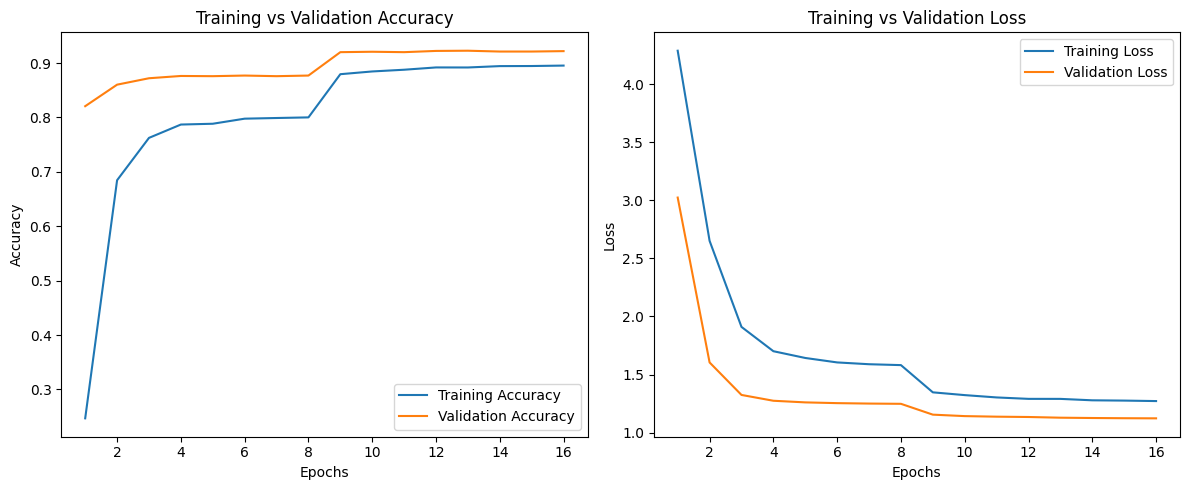

In [ ]:

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(epochs, acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


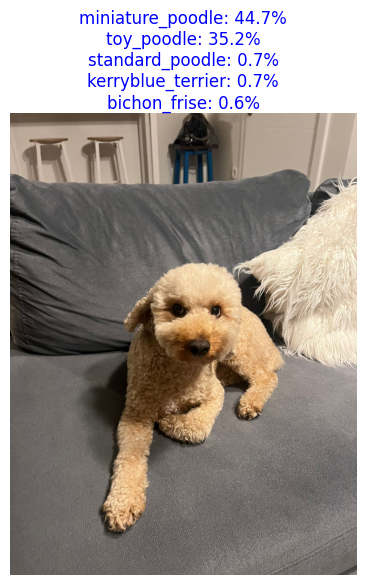

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# ---------------- Load model ----------------
model_indtest = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/dog_breed_classifier_ft1.keras")

# Path to your dataset (for class names)
class_names = sorted(os.listdir(dataset_path))

# Must match training size
img_size = (384, 384)

def predict_and_show(img_path):
    img = Image.open(img_path).convert("RGB")
    img_resized = img.resize(img_size)
    arr = np.array(img_resized)
    arr = preprocess_input(arr)
    arr = np.expand_dims(arr, axis=0)

    preds = model_indtest.predict(arr)[0]
    top5_idx = preds.argsort()[-5:][::-1]  # top-5 indices

    # Build a multiline title with top-5 predictions
    title = "\n".join([f"{class_names[i]}: {preds[i]*100:.1f}%" for i in top5_idx])

    # Show image with top-5 above it
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title, fontsize=12, color="blue", loc="center", wrap=True)
    plt.show()



# ---------------- Example usage ----------------
predict_and_show(r"/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/taco.jpg")